In [ ]:
####SUCCESFUL: IMPORTANT

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300/1000
emiss = 0.5


In [3]:
label = "Navier_stan"

x = np.linspace(0,1,250).reshape(-1,1)
y = np.linspace(0,1,250).reshape(-1,1)
#t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
 
xy = np.hstack((X,Y))

#initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

DBC_pts = (Y == 0).reshape(-1,)


NBC_pts_x0 = (X == 0).reshape(-1,)
NBC_pts_x1 = (X == 1).reshape(-1,)

NBC_pts_y0 = (Y == 0).reshape(-1,)
NBC_pts_y1 = (Y == 1).reshape(-1,)

#xy_initial = xyt[initial_pts,:]
xy_DBC = xy[DBC_pts,:]

xy_NBC_x0 = xy[NBC_pts_x0,:]
xy_NBC_x1 = xy[NBC_pts_x1,:]

#xyt_NBC_y0 = xyt[NBC_pts_y0,:]
xy_NBC_y1 = xy[NBC_pts_y1,:]

#u_initial = np.zeros((np.shape(xy_initial)[0],1))
u_DBC = 1*np.ones((np.shape(xy_DBC)[0],1)) #Scaling by 1000

#xy_I_DBC = np.vstack((xy_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xy_NBC_x = np.vstack((xy_NBC_x0,xy_NBC_x1))
#xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
xy_NBC_y = np.vstack((xy_NBC_y1))

#u_I_DBC = np.vstack((u_initial,u_DBC))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xy_DBC.shape[0], N_D, replace=False) 
    xy_D = xy_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xy_NBC_x.shape[0], N_D, replace=False) 
    xy_Nx = xy_NBC_x[idx,:] #choose indices from  set 'idx' (x,t)

    idx = np.random.choice(xy_NBC_y.shape[0], N_D, replace=False) 
    xy_Ny = xy_NBC_y[idx,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    xy_coll = np.vstack((xy_coll, xy_D,xy_Nx,xy_Ny)) # append training points to collocation points 

    return xy_coll, xy_D, u_D, xy_Nx,xy_Ny

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)

                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
            #a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xy_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xy_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xy_Nx,xy_Ny,N_hat):
        
        g1 = xy_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y = autograd.grad(u1,g1,torch.ones([xy_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y[:,[0]]
        
        g2 = xy_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y = autograd.grad(u2,g2,torch.ones([xy_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = - 1000*k*t_z*(d2u_dx2+d2u_dy2) + 1000*2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(1000*u,4)-(1000*Ta)**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_D,u_D,xy_Nx,xy_Ny,N_hat,xy_coll,f_hat):

        loss_D = self.loss_D(xy_D,u_D)
        loss_N = self.loss_N(xy_Nx,xy_Ny,N_hat)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xy_D,u_D,xy_Nx,xy_Ny,N_hat,xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xy_test_tensor):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

for reps in range(max_reps):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 100 #Total number of data points for 'y'
    N_N = 3500
    N_f = 10000 #Total number of collocation points 
    
    xy_coll_np_array, xy_D_np_array, u_D_np_array,xy_Nx_np_array,xy_Ny_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_D = torch.from_numpy(xy_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xy_Nx = torch.from_numpy(xy_Nx_np_array).float().to(device)
    xy_Ny = torch.from_numpy(xy_Ny_np_array).float().to(device)
        
    N_hat = torch.zeros(xy_Nx.shape[0],1).to(device)    
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)

    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic)

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 1544169.9
1 Train Loss 760948.44
2 Train Loss 56458.312
3 Train Loss 50984.734
4 Train Loss 49212.754
5 Train Loss 36747.734
6 Train Loss 12836.262
7 Train Loss 4465.0576
8 Train Loss 4189.278
9 Train Loss 4144.6367
10 Train Loss 3988.931
11 Train Loss 3699.8643
12 Train Loss 3179.586
1

310 Train Loss 0.7870444
311 Train Loss 0.7870457
312 Train Loss 0.78704923
313 Train Loss 0.7870536
314 Train Loss 0.7870444
315 Train Loss 0.7870457
316 Train Loss 0.78704923
317 Train Loss 0.7870536
318 Train Loss 0.7870444
319 Train Loss 0.7870457
320 Train Loss 0.78704923
321 Train Loss 0.7870536
322 Train Loss 0.7870444
323 Train Loss 0.7870457
324 Train Loss 0.78704923
325 Train Loss 0.7870536
326 Train Loss 0.7870444
327 Train Loss 0.7870457
328 Train Loss 0.78704923
329 Train Loss 0.7870536
330 Train Loss 0.7870444
331 Train Loss 0.7870457
332 Train Loss 0.78704923
333 Train Loss 0.7870536
334 Train Loss 0.7870444
335 Train Loss 0.7870457
336 Train Loss 0.78704923
337 Train Loss 0.7870536
338 Train Loss 0.7870444
339 Train Loss 0.7870457
340 Train Loss 0.78704923
341 Train Loss 0.7870536
342 Train Loss 0.7870444
343 Train Loss 0.7870457
344 Train Loss 0.78704923
345 Train Loss 0.7870536
346 Train Loss 0.7870444
347 Train Loss 0.7870457
348 Train Loss 0.78704923
349 Train Loss 

639 Train Loss 0.7870457
640 Train Loss 0.78704923
641 Train Loss 0.7870536
642 Train Loss 0.7870444
643 Train Loss 0.7870457
644 Train Loss 0.78704923
645 Train Loss 0.7870536
646 Train Loss 0.7870444
647 Train Loss 0.7870457
648 Train Loss 0.78704923
649 Train Loss 0.7870536
650 Train Loss 0.7870444
651 Train Loss 0.7870457
652 Train Loss 0.78704923
653 Train Loss 0.7870536
654 Train Loss 0.7870444
655 Train Loss 0.7870457
656 Train Loss 0.78704923
657 Train Loss 0.7870536
658 Train Loss 0.7870444
659 Train Loss 0.7870457
660 Train Loss 0.78704923
661 Train Loss 0.7870536
662 Train Loss 0.7870444
663 Train Loss 0.7870457
664 Train Loss 0.78704923
665 Train Loss 0.7870536
666 Train Loss 0.7870444
667 Train Loss 0.7870457
668 Train Loss 0.78704923
669 Train Loss 0.7870536
670 Train Loss 0.7870444
671 Train Loss 0.7870457
672 Train Loss 0.78704923
673 Train Loss 0.7870536
674 Train Loss 0.7870444
675 Train Loss 0.7870457
676 Train Loss 0.78704923
677 Train Loss 0.7870536
678 Train Loss 

KeyboardInterrupt: 

In [7]:
u_pred = PINN.test(xy_test_tensor)
u_pred_3d = u_pred.reshape(250,250)

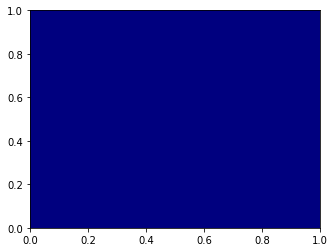

In [10]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(1000*u_pred_3d),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [11]:
np.min(u_pred_3d)

0.24514565

In [ ]:
u_pred_3d

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)